# Import library

In [1]:
%matplotlib inline

from obspy.clients.fdsn import Client
from obspy import Stream, UTCDateTime, Trace, read
import numpy as np
import matplotlib.pyplot as plt

# Use IRIS to download US and CA array
Specify in the next cell:
* event epicenter coordinates
* network names
* seed file name to store downloaded data


In [18]:
# 2020 Samos/Izmir earthquake, coordinates
lat_ev, lon_ev = 45.412, 16.298


networks = ['LB', 'CT']
# networks = ['CN','AK', 'AZ', 'BK', 'CI', 'CT', 'LB', 'LD', 'MB', 'NE', 'NM','NN','SC','TS','US','UU','UW','WY']

# save the data under this name
st_name = 'my_name_is_stream.mseed'


## Let's make an inventory with chosen networks
* Choose the correct client. Here it is IRIS for US/CA arrays.


In [19]:
from obspy import Inventory
client = Client('IRIS')

# all stats of CN
print (networks[0])
inv = client.get_stations(network=networks[0], station='*')

# add the rest
for net in networks[1:]:
    print (net)
    try:
        inv += client.get_stations(network=net, station='*')
    except:
        pass
###
print ('*')

LB
CT
*


## Plot the stations in the inventory on map
I used a distance criterion: 30-90 deg to epicenter

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


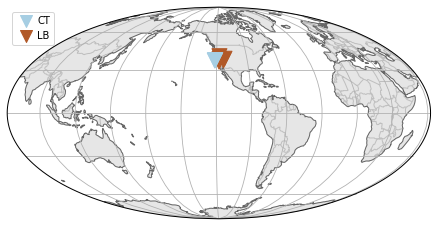

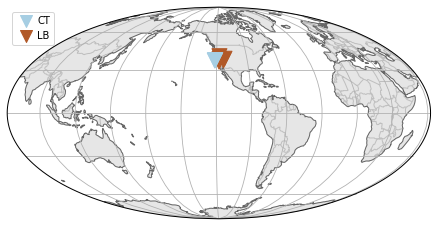

In [20]:
# select by dist to izmir within 30-90 deg
my_inv = inv.select(latitude=lat_ev, longitude=lon_ev, minradius=30, maxradius=90)

my_inv.plot(label=False, proj='local', color_per_network=True, show=False)


## Quick check of station numbers per network

In [21]:
nsta = 0
for net in my_inv:
    print (net.code, len(net))
    nsta += len(net)
print ('Total nb of stations: ', nsta)

LB 5
CT 3
Total nb of stations:  8


## 2) Let the download begin
- change the event time, evtime, and channel, if necessary.
- by default, 1 min of data will be downloaded.

In [23]:
to_download = True 

if to_download: 
    st = Stream() 
    
    # for each network in the inventory
    for net in my_inv:
        print ('*')
        print ('Network: ', net.code)
        loc ='*'
        compo = '??Z'
        evtime = '2020-12-29T11:19:54'
        starttime = UTCDateTime(evtime)
        endtime = starttime+ 60*60

        # for each station of the network
        for stat in net:
            sta = stat.code
            try:
                _st = client.get_waveforms(net.code, sta, loc, compo, starttime, endtime, attach_response=False)
                _st.merge(method=1)
                st += _st
                print ('........... station ok: ', sta)
            except:
                print ('........... station !!: ', sta)
                pass

    # now we have a stream
    # filled masked traces before writing out
    for tr in st:
        if isinstance(tr.data, np.ma.masked_array):
            tr.data = tr.data.filled()
    # write out
    st.write(st_name)
else:
    st = read(st_name)
###
print ('*')

*
Network:  LB
........... station ok:  BMN
........... station !!:  DAC
........... station !!:  LDS
........... station !!:  MVU
........... station ok:  TPH
*
Network:  CT
........... station !!:  FERN
........... station !!:  ICAN
........... station !!:  SAVY
*


## 3) Store the data
- Change the name of seed file if necessary
- I pick H?? and B?? data

In [25]:
# filter corner: how to choose?
my_st = st.copy()


# Processed data to store in
st_selected = my_st.select(channel='H??').copy()
st_selected += my_st.select(channel='B??').copy()

# save  
st_selected.write(st_name)

In [26]:
# obspy is cool!